In [2]:
import pickle
from typing import List, Tuple
import logging

import pandas as pd
import torch

from src.utils.paths import project_dir
    
    
data_filepath = project_dir() / 'data' / 'exp' / 'pressure_change.pkl'

with open(data_filepath, 'rb') as f:
    data = pickle.load(f)

test_data_sheet_path = project_dir() / 'data' / 'exp' / 'gp_exp_dataset.csv'
test_data_sheet = pd.read_csv(test_data_sheet_path, header=0)
test_data_sheet['test_num'] = test_data_sheet['test_num'].astype(int)
test_data_sheet['spark_x'] = test_data_sheet['spark_x'].astype(float)
test_data_sheet['spark_z'] = test_data_sheet['spark_z'].astype(float)
test_data_sheet['energy'] = test_data_sheet['energy'].astype(float)

trace_list = []
xi_list = []

for k, trace in data.items():

    def get_xi_from_run_number(run_number):
        matching_rows = test_data_sheet[test_data_sheet['test_num'] == run_number]

        if not len(matching_rows) == 1:
            return None

        row = matching_rows.iloc[0]
        xi = torch.tensor([row['spark_x'], row['spark_z'], row['energy']], dtype=torch.float32)
        return xi

    xi = get_xi_from_run_number(k)

    if xi is None:
        print(f"Run number {k} not found in test data sheet")
        continue

    xi_list.append(xi)

    trace = trace / 25000.0

    assert trace.min() >= -0.2, f"Min: {trace.min()}"
    assert trace.max() <= 2.5, f"Max: {trace.max()}"

    trace = torch.tensor(trace, dtype=torch.float32).view(-1, 1)

    trace_list.append(trace)

def normalise_xi_list(xi_list):
        xi_list = torch.stack(xi_list)
        xi_mean = xi_list.mean(dim=0)
        xi_std = xi_list.std(dim=0)
        print(f"xi_mean: {xi_mean}")
        print(f"xi_std: {xi_std}")
        xi_list = (xi_list - xi_mean) / xi_std
        return [x for x in xi_list]

xi_list = normalise_xi_list(xi_list)

/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_69050/770673675.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Run number 355 not found in test data sheet
Run number 345 not found in test data sheet
Run number 356 not found in test data sheet
Run number 359 not found in test data sheet
Run number 342 not found in test data sheet
Run number 340 not found in test data sheet
Run number 350 not found in test data sheet
Run number 343 not found in test data sheet
Run number 263 not found in test data sheet
Run number 264 not found in test data sheet
Run number 360 not found in test data sheet
Run number 357 not found in test data sheet
Run number 358 not found in test data sheet
Run number 349 not found in test data sheet
Run number 348 not found in test data sheet
Run number 344 not found in test data sheet
Run number 352 not found in test data sheet
Run number 351 not found in test data sheet
Run number 346 not found in test data sheet
Run number 354 not found in test data sheet
Run number 347 not found in test data sheet
Run number 353 not found in test data sheet
Run number 341 not found in test

In [3]:
xi_list_np = [x.numpy() for x in xi_list]
trace_list_np = [x.numpy() for x in trace_list]

In [4]:
rows = []
row_info = {}

for i, (xi, trace) in enumerate(zip(xi_list_np, trace_list_np)):
    
    for j in range(3):
        row_info[f'xi_{j}'] = xi[j]
        
    for j in range(25):
        row_info[f'p_{j}'] = trace[j][0]
        
    rows.append(row_info.copy())
    
df = pd.DataFrame(rows)
df

,xi_0,xi_1,xi_2,p_0,p_1,p_2,p_3,p_4,p_5,p_6,...,p_15,p_16,p_17,p_18,p_19,p_20,p_21,p_22,p_23,p_24
0,-1.950571,-0.047407,0.800346,-0.003536,-0.001966,-0.003467,-0.010712,-0.009321,-0.000690,-0.004921,...,0.611873,1.108728,1.223710,1.048397,0.857518,1.016490,0.783634,0.924630,1.095161,1.014021
1,0.624411,-0.245645,1.097010,-0.023135,-0.001641,-0.010342,-0.007414,-0.004477,0.027033,-0.034522,...,0.004204,0.026026,0.008330,0.011439,0.034058,-0.004467,0.028930,-0.027369,-0.001833,0.018885
2,0.691080,-0.239143,0.563582,-0.018924,-0.000215,-0.010324,-0.005990,-0.005954,0.004132,-0.021689,...,0.020034,0.036050,0.006890,0.017252,0.016811,0.009870,0.021450,-0.014437,0.009614,0.027179
3,1.218550,0.956901,0.646648,0.055271,0.013521,0.007608,0.001952,0.006315,0.013559,0.039190,...,0.017934,0.013474,0.007647,-0.022331,0.045012,0.021000,0.030507,-0.003902,0.020620,0.010546
4,0.154557,-1.445860,-1.120689,0.034273,0.002705,-0.013241,0.002598,-0.000425,0.011182,0.022695,...,-0.010939,0.050425,0.004092,0.009753,0.038740,0.009648,0.019865,-0.023097,0.042937,0.011379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,-1.975355,1.060113,0.208309,-0.005083,-0.003634,0.004988,0.006461,0.012209,0.012165,0.012199,...,0.949497,0.981486,0.896173,0.929796,0.752907,0.666077,0.797223,1.006200,0.957916,1.112027
187,-0.200227,0.926375,0.465749,0.033723,-0.000861,-0.002268,0.000689,0.009333,0.010775,0.056576,...,0.110488,0.198014,0.354745,0.467697,0.612896,0.827277,1.032982,1.135482,1.112859,1.188738
188,-0.506342,-1.421553,-1.250231,-0.115912,0.003810,-0.010622,-0.006237,-0.001901,-0.000522,0.112711,...,0.661852,0.741766,0.710286,0.948596,0.857203,0.608505,0.592761,0.367003,0.272849,0.293633
189,-1.799749,1.128934,0.784870,-0.040094,0.003130,0.003082,0.000196,0.008771,0.016121,0.011662,...,0.681659,0.740720,0.930027,1.002783,1.035782,0.917724,0.767374,0.818187,0.817269,1.015144


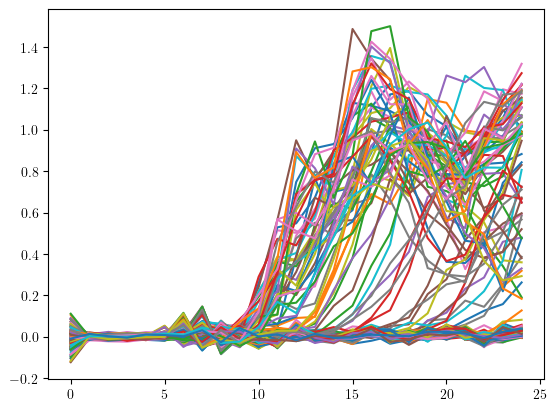

In [5]:
# Plot all pressure traces as a sanity check
import matplotlib.pyplot as plt

traces = df.iloc[:, 3:].values

for trace in traces:
    plt.plot(trace)
plt.show()

In [6]:
import json

with open("train_inds.json", "r") as f:
    train_inds = json.load(f)
    
with open("test_inds.json", "r") as f:
    test_inds = json.load(f)
    
train_df = df.iloc[train_inds]
test_df = df.iloc[test_inds]

train_df.to_csv("train.csv", index=False)
test_df.to_csv("val.csv", index=False)

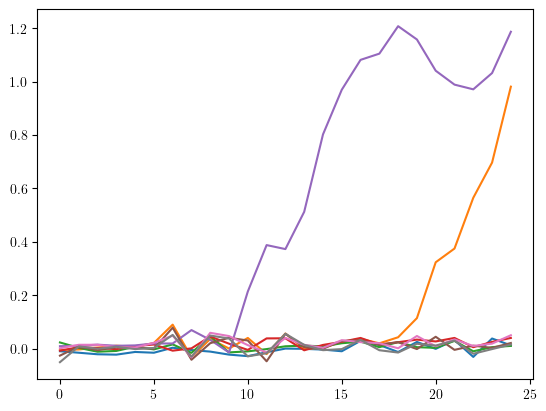

In [9]:
# Plot the first few test pressure traces
import matplotlib.pyplot as plt

traces = test_df.iloc[:, 3:].values

for trace in traces[:8]:
    plt.plot(trace)
    
plt.show()